In [1]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import Model 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from scipy.interpolate import make_interp_spline
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

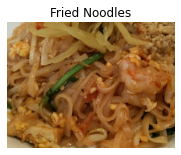

In [3]:
img = load_img('images/4012787089_d1cca54838.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Fried Noodles')
plt.show()

In [4]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

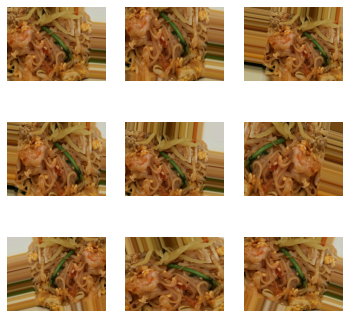

In [5]:
i = 0
fig = plt.figure(figsize = (6,6))
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

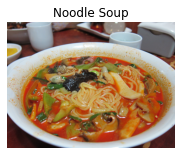

In [6]:
img = load_img('images/5153183161_eb845fb8d9_b.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Noodle Soup')
plt.show()

In [7]:
# configuración por defecto
img_width, img_height = 299, 299

train_dir = 'data/train'
validate_dir = 'data/validate'
nb_epochs = 20
batch_size = 32
nb_classes = len(glob.glob(train_dir + '/*'))

In [8]:
# obtener el número de imágenes en el directorio
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

315


In [9]:
# obtener el número de imágenes en el directorio de validación
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

36


In [10]:
# pre-procesamiento de datos para entrenamiento
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [11]:
# pre-procesamiento de datos para su validación
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [12]:
# generar y almacenar datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 315 images belonging to 2 classes.


In [13]:
# generar y almacenar datos de validación
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 36 images belonging to 2 classes.


In [14]:
# configurar el aprendizaje de transferencia en el modelo ImageNet Xception preentrenado 
# eliminar la capa totalmente conectada y reemplazarla con softmax para clasificar 2 clases
xcep_model = Xception(weights = 'imagenet', include_top = False)
x = xcep_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(xcep_model.input, predictions)

In [15]:
# congelar todas las capas del modelo previamente entrenado
for layer in xcep_model.layers:
    layer.trainable = False

In [16]:
# compile el nuevo modelo usando un optimizador RMSProp
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [17]:
# ajustar el modelo, registrar los resultados y el tiempo de entrenamiento
transfer_learning_history = model.fit(
    train_generator,
    epochs = nb_epochs,
    steps_per_epoch = len(train_generator),
    validation_data = validate_generator,
    validation_steps = len(validate_generator), verbose = 1)

Epoch 1/20
10/10 [==============================] - 42s 4s/step - loss: 0.7327 - accuracy: 0.8127 - val_loss: 0.3778 - val_accuracy: 0.8889
Epoch 2/20
10/10 [==============================] - 39s 4s/step - loss: 0.1616 - accuracy: 0.9524 - val_loss: 0.2193 - val_accuracy: 0.8889
Epoch 3/20
10/10 [==============================] - 38s 4s/step - loss: 0.1704 - accuracy: 0.9302 - val_loss: 0.3026 - val_accuracy: 0.9444
Epoch 4/20
10/10 [==============================] - 33s 3s/step - loss: 0.1550 - accuracy: 0.9365 - val_loss: 0.2965 - val_accuracy: 0.9167
Epoch 5/20
10/10 [==============================] - 43s 4s/step - loss: 0.1330 - accuracy: 0.9587 - val_loss: 0.2620 - val_accuracy: 0.9167
Epoch 6/20
10/10 [==============================] - 35s 3s/step - loss: 0.1636 - accuracy: 0.9460 - val_loss: 0.3930 - val_accuracy: 0.8889
Epoch 7/20
10/10 [==============================] - 38s 4s/step - loss: 0.1692 - accuracy: 0.9333 - val_loss: 0.2690 - val_accuracy: 0.9167
Epoch 8/20
10/10 [==

In [19]:
scores = model.evaluate(validate_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

2/2 [==============================] - 5s 507ms/step - loss: 0.5874 - accuracy: 0.9167
evaluate accuracy: 91.67%


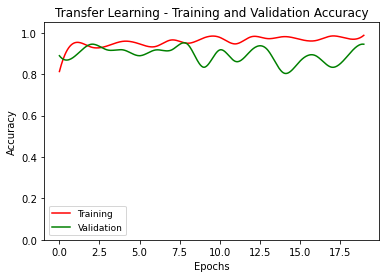

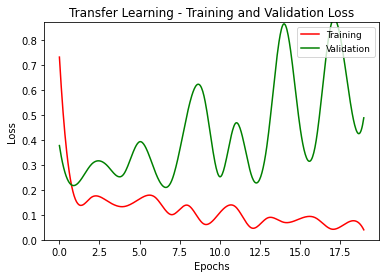

In [21]:
xfer_acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = make_interp_spline(x,y)(x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 500)
y1_smooth = make_interp_spline(x1,y1)(x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.05)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = make_interp_spline(x,y)(x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 500)
y1_smooth = make_interp_spline(x1,y1)(x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,max(y1))
plt.show()

In [22]:
validate_generator.total_batches_seen

47

In [23]:
predict_files = glob.glob("data/test/*.jpg")

In [24]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [25]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

In [26]:
final = pd.DataFrame()
final["id"] = image_id
final["Noodles"] = predictor
final.head(29)

,id,Noodles
0,noodles_fried_11907714416_43d097a388_b.jpg,0
1,noodles_fried_12773173773_8b979e09a3_b.jpg,0
2,noodles_fried_12780501384_e09c5c8e9e_b.jpg,0
3,noodles_fried_13465247115_3a5d9e8bda.jpg,0
4,noodles_fried_21801699575_797999fc3b_b.jpg,0
5,noodles_fried_2683621518_dd75c9ba12_b.jpg,0
6,noodles_fried_2725335486_4988c93cc4_b.jpg,0
7,noodles_fried_325511866_82e17cec74_b.jpg,0
8,noodles_fried_3959302738_054794e5e9_b.jpg,0
9,noodles_fried_4629495314_54b073df68_b.jpg,0


In [27]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [28]:
final["Noodles"] = final["Noodles"].apply(lambda x: classes[x])
final.head(29)

,id,Noodles
0,noodles_fried_11907714416_43d097a388_b.jpg,noodles_fried
1,noodles_fried_12773173773_8b979e09a3_b.jpg,noodles_fried
2,noodles_fried_12780501384_e09c5c8e9e_b.jpg,noodles_fried
3,noodles_fried_13465247115_3a5d9e8bda.jpg,noodles_fried
4,noodles_fried_21801699575_797999fc3b_b.jpg,noodles_fried
5,noodles_fried_2683621518_dd75c9ba12_b.jpg,noodles_fried
6,noodles_fried_2725335486_4988c93cc4_b.jpg,noodles_fried
7,noodles_fried_325511866_82e17cec74_b.jpg,noodles_fried
8,noodles_fried_3959302738_054794e5e9_b.jpg,noodles_fried
9,noodles_fried_4629495314_54b073df68_b.jpg,noodles_fried


In [29]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________